<a href="https://colab.research.google.com/github/brianellis1997/Sarcasm_Detection/blob/Brian_token/DS_440_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection using NLP Techniques
### Team 2: Brian Ellis, Lindsey Rich, Elena Kern

## Load Libraries and Dataset

In [2]:
import pandas as pd
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#test comment

In [3]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [4]:
!git clone https://github.com/brianellis1997/Sarcasm_Detection.git

Cloning into 'Sarcasm_Detection'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 68 (delta 34), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (68/68), 670.91 KiB | 6.45 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_bal = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/train-balanced-sarcasm.csv')   # Make sure path is correct in your google drive
train_bal.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [ ]:
train_bal.info()

In [ ]:
train_bal['label'].value_counts()

We can see our dataset is balanced.

In [ ]:
train_bal['comment'] = train_bal['comment'].astype('str')
train_bal.info()

In [ ]:
train_bal[:20]['comment']

## EDA

In [8]:
# Separating sarcastic vs non sarcastic comments
sarcastic_com = train_bal[train_bal['label'] == 1]
non_sarcastic_com = train_bal[train_bal['label'] == 0]

In [ ]:
# # WordCloud for sarcastic comments
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sarcastic_com['comment'].values.ravel()))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [ ]:
# # WordCloud for non-sarcastic comments
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_sarcastic_com['comment'].values.ravel()))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

# Visualizing Sarcastic Comments by Subreddit

In [9]:
subreddit_count = sarcastic_com['subreddit'].value_counts()

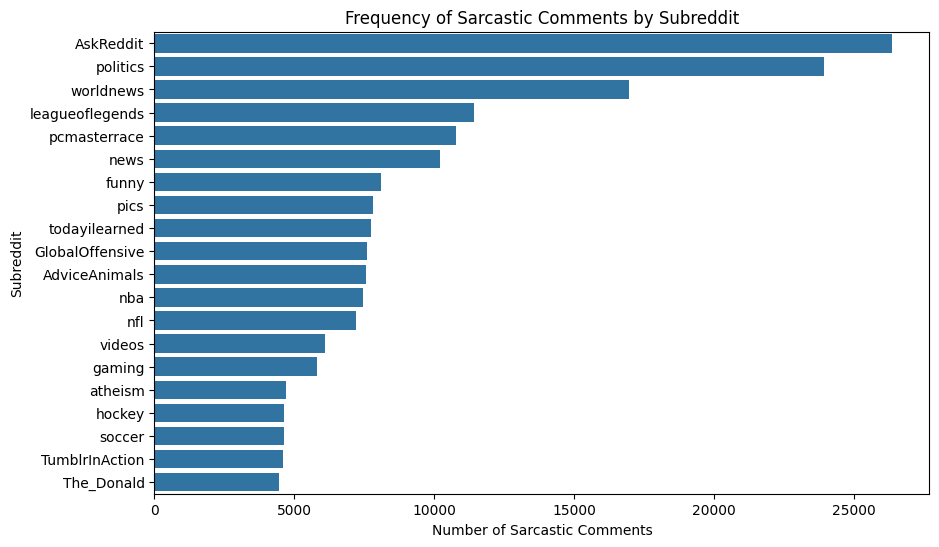

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
top = subreddit_count.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top.values, y=top.index)
plt.xlabel('Number of Sarcastic Comments')
plt.ylabel('Subreddit')
plt.title('Frequency of Sarcastic Comments by Subreddit')
plt.show()


In [11]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')

import string

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

import spacy # for a lemmatization example

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
comments = train_bal['comment']

In [13]:
comments.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1010826 entries, 0 to 1010825
Series name: comment
Non-Null Count    Dtype 
--------------    ----- 
1010773 non-null  object
dtypes: object(1)
memory usage: 7.7+ MB


In [14]:
comments.dropna(inplace=True)
comments.info()

<class 'pandas.core.series.Series'>
Int64Index: 1010773 entries, 0 to 1010825
Series name: comment
Non-Null Count    Dtype 
--------------    ----- 
1010773 non-null  object
dtypes: object(1)
memory usage: 15.4+ MB


In [15]:
!pip install dask[delayed]

In [16]:
import dask.dataframe as dd
from dask import delayed

In [17]:
comment_test = comments.head(10000)

In [18]:
#  Replace this?
def batch_tokenize(texts, batch_size=50000):
    tokenized_texts = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        tokenized_batch = [word_tokenize(text) for text in batch]
        tokenized_texts.extend(tokenized_batch)
    return tokenized_texts

tokenized_comments = batch_tokenize(comments.tolist())

In [19]:
len(tokenized_comments)

1010773

In [21]:
phrases = Phrases(tokenized_comments)

In [22]:
bigram = Phraser(phrases)

In [ ]:
# bigram.phrasegrams

In [23]:
bigram_comments = [bigram[comment] for comment in tokenized_comments]


In [24]:
# Adjust parameters as needed
size = 150
window = 7
min_count = 15
workers = 4
sg = 1
negative = 5
epochs = 7


model = Word2Vec(bigram_comments, vector_size=size, window=window, min_count=min_count, workers=workers)

# model.save("/content/drive/Sarcasm_Data/model/word2vec.w2v")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Sarcasm_Data/model/word2vec.model'

In [26]:
# model.save("model_embedding.w2v")

In [27]:
# skip re-training the model with the next line:
model = gensim.models.Word2Vec.load('/content/drive/Sarcasm_Data/model_embedding.w2v')

In [28]:
model.wv['dog']

array([ 1.0188653 ,  0.32062483, -0.07807237,  0.85903114,  0.04362991,
       -1.1928818 ,  0.45977163,  0.37797037,  0.8945798 ,  0.82961595,
       -0.03136215, -0.49116868, -0.7461801 , -0.4845558 , -0.9324936 ,
        0.07049374, -0.12309556,  0.57161343,  0.4969225 ,  0.31674108,
       -2.4375882 ,  0.9702497 ,  0.01775967, -0.28214842,  0.8720666 ,
       -1.00265   ,  0.6558143 , -0.7604041 , -1.4459295 , -0.28646892,
       -1.2925223 , -0.7026893 ,  0.85467094,  1.3778654 ,  0.9994284 ,
       -1.1475997 , -0.34346926,  0.741116  ,  0.48441404, -1.3507508 ,
       -0.51482826, -0.6061933 , -0.00591656,  0.77143335,  0.44804016,
       -0.11711957,  0.08903364,  0.26260948,  0.01116152,  1.9489256 ,
       -0.2577452 ,  0.553156  ,  0.3978653 ,  1.8590658 ,  1.3861057 ,
        0.30002668,  1.8992883 , -1.2189982 ,  1.4793862 , -0.17094561,
        0.7126899 ,  0.37536767,  0.9446461 , -0.47818613,  0.39467183,
        0.4380137 ,  0.8973546 , -0.35694343, -0.34861717, -0.08

In [29]:
similar_words = model.wv.most_similar('ok')
similar_words

[('okay', 0.9476559162139893),
 ('OK', 0.915338397026062),
 ('alright', 0.7750617265701294),
 ('fine', 0.6628554463386536),
 ('cool', 0.5893252491950989),
 ('perfectly_fine', 0.5848596096038818),
 ('pretty_obvious', 0.5256322622299194),
 ('pretty_close', 0.5119588971138),
 ('justified', 0.49507829546928406),
 ('wrong', 0.4906427562236786)]

In [30]:
model.wv.doesnt_match("mother father sister brother dog".split())

'dog'

In [31]:
model.wv.similarity('father', 'dog')

0.67697096

In [32]:
model.wv.most_similar(positive=['father', 'woman'], negative=['man'])   # Should expect mother

[('mother', 0.7333528995513916),
 ('child', 0.6821308135986328),
 ('husband', 0.6604435443878174),
 ('daughter', 0.6524917483329773),
 ('wife', 0.6470549702644348),
 ('teacher', 0.63566654920578),
 ('girlfriend', 0.6241698265075684),
 ('sister', 0.6156890988349915),
 ('parent', 0.6142110228538513),
 ('cousin', 0.5869983434677124)]

In [33]:
model.wv.most_similar(positive=['husband', 'woman'], negative=['man'])  # Should expect wife

[('mother', 0.6858645081520081),
 ('child', 0.6771438121795654),
 ('daughter', 0.6768690347671509),
 ('partner', 0.6554784774780273),
 ('girlfriend', 0.6529251337051392),
 ('father', 0.6479963660240173),
 ('boyfriend', 0.6227932572364807),
 ('wife', 0.6187699437141418),
 ('sister', 0.6163711547851562),
 ('neighbor', 0.6010925769805908)]

### t-SNE Word Embedding Visualization

In [34]:
# tsne = TSNE(n_components=2, n_iter=1000)

In [38]:
# # X_2d = tsne.fit_transform(model.wv[model.wv.key_to_index])
# coords_df = pd.DataFrame(X_2d, columns=['x','y'])
# coords_df['token'] = model.wv.index_to_key
# # coords_df.head()
# coords_df.to_csv('word_embedding_tsne.csv', index=False)

In [42]:
coords_df = pd.read_csv('/Sarcasm_Detection/word_embedding_tsne.csv')
output_notebook()
subset_df = coords_df.sample(n=5000)
p = figure(min_width=800, min_height=800)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)
show(p)

# Start LSTM architecture with these initial embeddings before BERT


# Need to create embeddings matrix for LSTM


In [ ]:
model = Word2Vec.load("/content/word2vec.model")
